## Importing Libraries

In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scipy.spatial.distance as distance
import pytz
import numpy as np
pd.set_option('display.max_columns', None)

###  Loading and reading data

In [2]:
data = pd.DataFrame()
for csv in glob.glob('New Folder/*'):
    #extract user uuid
    uuid = csv.split('\\')[1].split('.')[0]
    
    #read user csv file
    df = pd.read_csv(csv)

    #insert user uuid column
    df.insert(loc=0, column='uuid', value=uuid)
    data = data.append(df)

In [3]:
data.head()

,uuid,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,raw_acc:magnitude_spectrum:log_energy_band1,raw_acc:magnitude_spectrum:log_energy_band2,raw_acc:magnitude_spectrum:log_energy_band3,raw_acc:magnitude_spectrum:log_energy_band4,raw_acc:magnitude_spectrum:spectral_entropy,raw_acc:magnitude_autocorrelation:period,raw_acc:magnitude_autocorrelation:normalized_ac,raw_acc:3d:mean_x,raw_acc:3d:mean_y,raw_acc:3d:mean_z,raw_acc:3d:std_x,raw_acc:3d:std_y,raw_acc:3d:std_z,raw_acc:3d:ro_xy,raw_acc:3d:ro_xz,raw_acc:3d:ro_yz,proc_gyro:magnitude_stats:mean,proc_gyro:magnitude_stats:std,proc_gyro:magnitude_stats:moment3,proc_gyro:magnitude_stats:moment4,proc_gyro:magnitude_stats:percentile25,proc_gyro:magnitude_stats:percentile50,proc_gyro:magnitude_stats:percentile75,proc_gyro:magnitude_stats:value_entropy,proc_gyro:magnitude_stats:time_entropy,proc_gyro:magnitude_spectrum:log_energy_band0,proc_gyro:magnitude_spectrum:log_energy_band1,proc_gyro:magnitude_spectrum:log_energy_band2,proc_gyro:magnitude_spectrum:log_energy_band3,proc_gyro:magnitude_spectrum:log_energy_band4,proc_gyro:magnitude_spectrum:spectral_entropy,proc_gyro:magnitude_autocorrelation:period,proc_gyro:magnitude_autocorrelation:normalized_ac,proc_gyro:3d:mean_x,proc_gyro:3d:mean_y,proc_gyro:3d:mean_z,proc_gyro:3d:std_x,proc_gyro:3d:std_y,proc_gyro:3d:std_z,proc_gyro:3d:ro_xy,proc_gyro:3d:ro_xz,proc_gyro:3d:ro_yz,raw_magnet:magnitude_stats:mean,raw_magnet:magnitude_stats:std,raw_magnet:magnitude_stats:moment3,raw_magnet:magnitude_stats:moment4,raw_magnet:magnitude_stats:percentile25,raw_magnet:magnitude_stats:percentile50,raw_magnet:magnitude_stats:percentile75,raw_magnet:magnitude_stats:value_entropy,raw_magnet:magnitude_stats:time_entropy,raw_magnet:magnitude_spectrum:log_energy_band0,raw_magnet:magnitude_spectrum:log_energy_band1,raw_magnet:magnitude_spectrum:log_energy_band2,raw_magnet:magnitude_spectrum:log_energy_band3,raw_magnet:magnitude_spectrum:log_energy_band4,raw_magnet:magnitude_spectrum:spectral_entropy,raw_magnet:magnitude_autocorrelation:period,raw_magnet:magnitude_autocorrelation:normalized_ac,raw_magnet:3d:mean_x,raw_magnet:3d:mean_y,raw_magnet:3d:mean_z,raw_magnet:3d:std_x,raw_magnet:3d:std_y,raw_magnet:3d:std_z,raw_magnet:3d:ro_xy,raw_magnet:3d:ro_xz,raw_magnet:3d:ro_yz,raw_magnet:avr_cosine_similarity_lag_range0,raw_magnet:avr_cosine_similarity_lag_range1,raw_magnet:avr_cosine_similarity_lag_range2,raw_magnet:avr_cosine_similarity_lag_range3,raw_magnet:avr_cosine_similarity_lag_range4,watch_acceleration:magnitude_stats:mean,watch_acceleration:magnitude_stats:std,watch_acceleration:magnitude_stats:moment3,watch_acceleration:magnitude_stats:moment4,watch_acceleration:magnitude_stats:percentile25,watch_acceleration:magnitude_stats:percentile50,watch_acceleration:magnitude_stats:percentile75,watch_acceleration:magnitude_stats:value_entropy,watch_acceleration:magnitude_stats:time_entropy,watch_acceleration:magnitude_spectrum:log_energy_band0,watch_acceleration:magnitude_spectrum:log_energy_band1,watch_acceleration:magnitude_spectrum:log_energy_band2,watch_acceleration:magnitude_spectrum:log_energy_band3,watch_acceleration:magnitude_spectrum:log_energy_band4,watch_acceleration:magnitude_spectrum:spectral_entropy,watch_acceleration:magnitude_autocorrelation:period,watch_acceleration:magnitude_autocorrelation:normalized_ac,watch_acceleration:3d:mean_x,watch_acceleration:3d:mean_y,watch_acceleration:3d:mean_z,watch_acceleration:3d:std_x,watch_acceleration:3d:std_y,watch_acceleration:3d:std_z,watch_acceleration:3d:ro_xy,watch_acceleration:3d:ro_xz,watch_acceleration:3d:ro_yz,watch_acceleration:spectrum:x_log_energy_band0,watch_acceleration:spectrum:x_log_ene

### EDA

In [4]:
# find first occurence of labels to spilt data into features and labels
first_label_index = 0
for i, col in enumerate(data.columns):
    if 'label' in col:
        first_label_index = i
        break

In [5]:
# insert user uuid and timestamp into labels data
labels = data.iloc[:, first_label_index:]
to_insert = [data.uuid, data.timestamp]
for i in range(len(to_insert)):
    labels.insert(loc=i, column=data.columns[i], value=to_insert[i])

In [6]:
# clean label names
columns = []
for col in labels.columns[2:-1]:
    a = col.split(":")[1].lower()
    if a.startswith('fix') or a.startswith('loc') or a.startswith('or'):
        a = " ".join(a.split("_")[1:])
    a = a.replace("_", " ")
    columns.append(a)

labels.columns = labels.columns[:2].to_list() + columns + [labels.columns[-1]]

In [7]:
labels.head()

,uuid,timestamp,lying down,sitting,walking,running,bicycling,sleeping,lab work,in class,in a meeting,main workplace,indoors,outside,in a car,on a bus,drive - i m the driver,drive - i m a passenger,home,restaurant,phone in pocket,exercise,cooking,shopping,strolling,drinking alcohol,bathing - shower,cleaning,doing laundry,washing dishes,watching tv,surfing the internet,at a party,at a bar,beach,singing,talking,computer work,eating,toilet,grooming,dressing,at the gym,stairs - going up,stairs - going down,elevator,standing,at school,phone in hand,phone in bag,phone on table,with co-workers,with friends,label_source
0,00EABED2-271D-49D8-B599-1D4A09240601,1444079161,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
1,00EABED2-271D-49D8-B599-1D4A09240601,1444079221,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
2,00EABED2-271D-49D8-B599-1D4A09240601,1444079281,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
3,00EABED2-271D-49D8-B599-1D4A09240601,1444079341,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
4,00EABED2-271D-49D8-B599-1D4A09240601,1444079431,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2


### Finding most engaging activities

In [8]:
# group and and caluclaute average minutes by activites per user
activities_by_minutes = labels.groupby('uuid').sum()
activities_by_minutes = activities_by_minutes.iloc[:, 1:-1]
activities_by_minutes.head()

,lying down,sitting,walking,running,bicycling,sleeping,lab work,in class,in a meeting,main workplace,indoors,outside,in a car,on a bus,drive - i m the driver,drive - i m a passenger,home,restaurant,phone in pocket,exercise,cooking,shopping,strolling,drinking alcohol,bathing - shower,cleaning,doing laundry,washing dishes,watching tv,surfing the internet,at a party,at a bar,beach,singing,talking,computer work,eating,toilet,grooming,dressing,at the gym,stairs - going up,stairs - going down,elevator,standing,at school,phone in hand,phone in bag,phone on table,with co-workers,with friends
uuid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00EABED2-271D-49D8-B599-1D4A09240601,657.0,1106.0,163.0,0.0,0.0,477.0,0.0,214.0,306.0,197.0,1284.0,0.0,0.0,49.0,0.0,0.0,995.0,0.0,0.0,0.0,55.0,19.0,0.0,0.0,15.0,38.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,54.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,193.0,0.0,0.0,0.0,1594.0,331.0,0.0
098A72A5-E3E5-4F54-A152-BBDA0DF7B694,2724.0,2246.0,187.0,33.0,120.0,1742.0,89.0,0.0,81.0,2322.0,2759.0,14.0,117.0,0.0,108.0,34.0,2809.0,0.0,0.0,350.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,136.0,0.0,0.0,8.0,0.0,221.0,1346.0,25.0,26.0,16.0,10.0,0.0,1.0,1.0,0.0,158.0,890.0,242.0,0.0,505.0,0.0,0.0
0A986513-7828-4D53-AA1F-E02D6DF9561B,1145.0,2253.0,190.0,7.0,0.0,1145.0,0.0,0.0,0.0,0.0,2177.0,77.0,0.0,0.0,0.0,0.0,1784.0,0.0,300.0,7.0,0.0,0.0,0.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,537.0,0.0,136.0,41.0,0.0,47.0,0.0,25.0,8.0,0.0,284.0,753.0,0.0,0.0,553.0,0.0,1648.0
0BFC35E2-4817-4865-BFA7-764742302A2D,0.0,1301.0,375.0,35.0,106.0,0.0,0.0,0.0,206.0,0.0,648.0,44.0,0.0,9.0,136.0,0.0,1223.0,0.0,68.0,141.0,65.0,0.0,0.0,0.0,0.0,22.0,24.0,80.0,59.0,0.0,0.0,0.0,0.0,0.0,96.0,512.0,108.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,370.0,892.0,35.0,0.0,200.0,364.0,127.0
0E6184E1-90C0-48EE-B25A-F1ECB7B9714E,1989.0,3089.0,1532.0,0.0,0.0,1312.0,0.0,647.0,63.0,517.0,4549.0,546.0,42.0,54.0,0.0,0.0,2494.0,137.0,0.0,0.0,331.0,48.0,0.0,0.0,88.0,828.0,0.0,0.0,62.0,231.0,0.0,0.0,0.0,0.0,2438.0,0.0,376.0,96.0,116.0,118.0,0.0,78.0,87.0,0.0,866.0,1069.0,0.0,0.0,107.0,840.0,2418.0


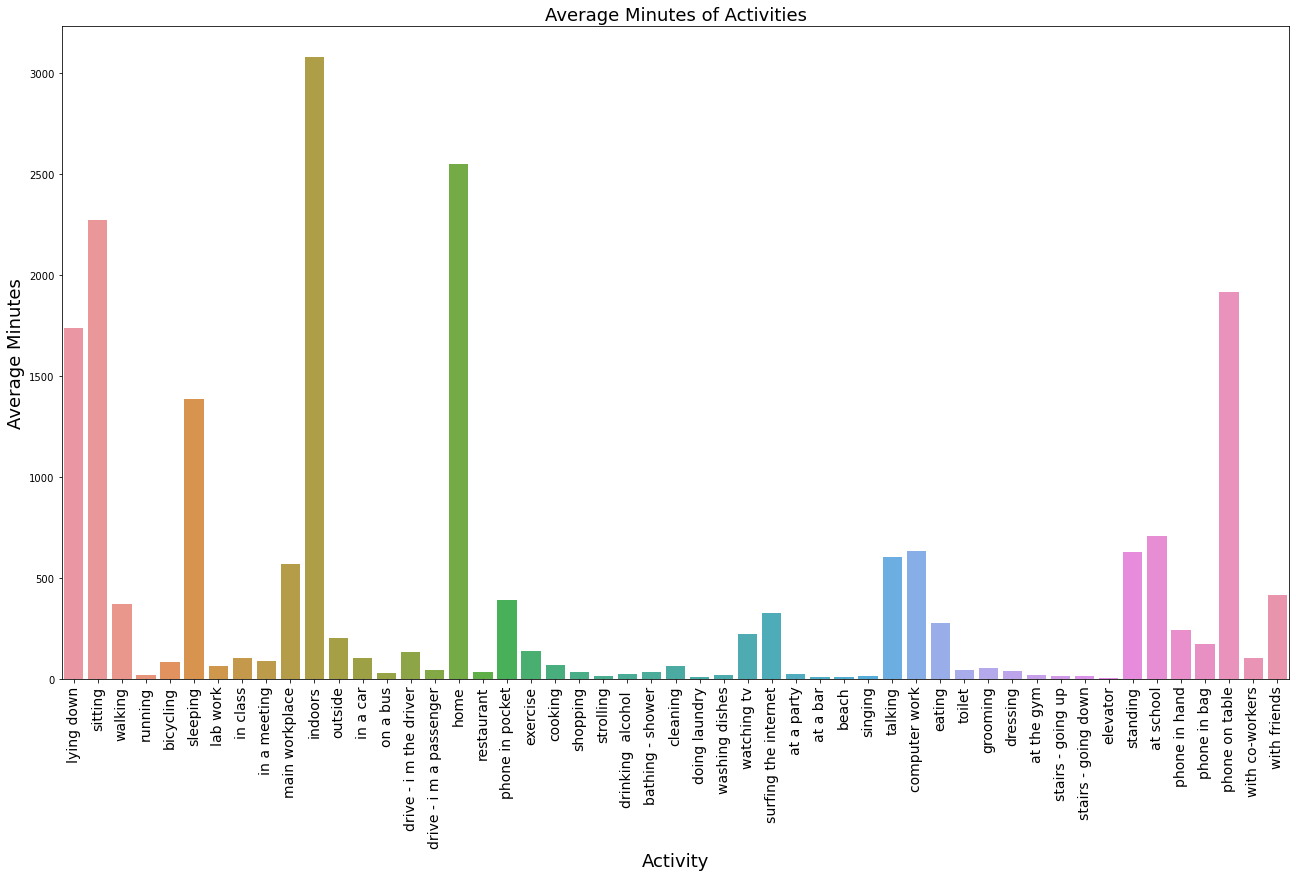

In [9]:
# summary statistics on actitivties
stats = activities_by_minutes.describe().T
plt.figure(figsize=(22, 12))
sns.barplot(data=stats, y = 'mean', x=stats.index)
plt.xticks(rotation=90, fontsize=14)
plt.title('Average Minutes of Activities', fontsize=18)
plt.xlabel('Activity', fontsize=18)
plt.ylabel('Average Minutes', fontsize=18)
plt.show()

<center>The labels in this dataset are as follows:</center>

|               |                   |               |
| ------------- | ----------------- | ------------- |
| Lying down  | Phone in pocket     | Stairs - going down      |
| Sitting     | Drinking alcohol   | At the gym    |
| Cooking     | Watching tv     | At a bar      |
| Walking     | At a party   | Surfing the internet    |
| Running     | Computer work     | Bathing - shower      |
| Bicycling   | Stairs - going up   | Talking    |
| Sleeping    | Elevator     | Singing      |
| Lab work    | Strolling   | Washing dishes    |
| In class    | Cleaning     | Doing laundry      |
| In a meeting| Eating   | Dressing    |
| Main workplace     | Standing     | Grooming      |
| Indoors     | Phone in hand   | Toilet    |
| Outside     | Phone on table   | Beach    |
| In a car     | With friends     | Home      |
| On a bus     | With co-workers   | Restaurant    |
| Drive - I'm the driver     | Phone in bag     | Exercise      |
| Drive - I'm a passenger     | At school   | Shopping    |

### Co-occurence of Labels

In [13]:
jaccard_similarity_df = pd.DataFrame(columns = labels.columns[2:-1], index = labels.columns[2:-1])
similarity = labels.fillna(0)

In [14]:
for col in jaccard_similarity_df.columns:
    for index in jaccard_similarity_df.index:
        jaccard_similarity_df.loc[index, col] = 1 - distance.jaccard(similarity.loc[:,index], similarity.loc[:,col])

In [16]:
jaccard_similarity_df = jaccard_similarity_df.astype('float')

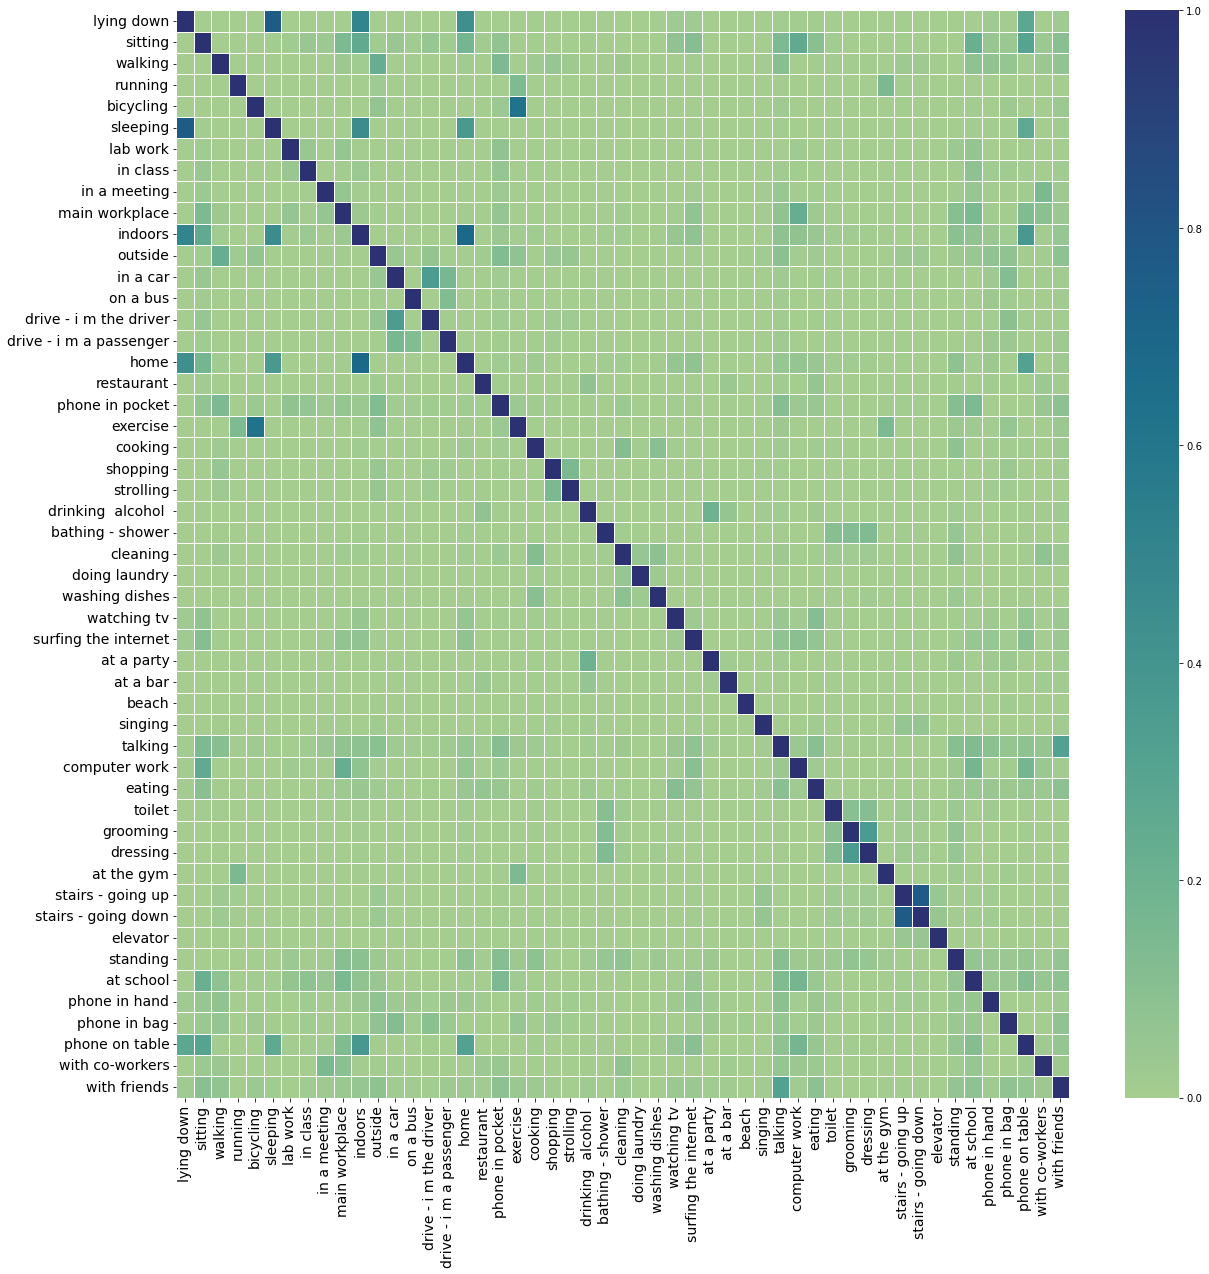

In [64]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(jaccard_similarity_df, linewidth=.5, cmap='crest')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The highly co-occurring labels in this dataset are as follows:

* Lying down and sleeping
* Lying down and indoors
* Home and indoors
* Exercise and bicycling
* Going up and down the stairs

### Sensors used

In [18]:
features = data.iloc[:, :first_label_index]
features.head()

,uuid,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,raw_acc:magnitude_spectrum:log_energy_band1,raw_acc:magnitude_spectrum:log_energy_band2,raw_acc:magnitude_spectrum:log_energy_band3,raw_acc:magnitude_spectrum:log_energy_band4,raw_acc:magnitude_spectrum:spectral_entropy,raw_acc:magnitude_autocorrelation:period,raw_acc:magnitude_autocorrelation:normalized_ac,raw_acc:3d:mean_x,raw_acc:3d:mean_y,raw_acc:3d:mean_z,raw_acc:3d:std_x,raw_acc:3d:std_y,raw_acc:3d:std_z,raw_acc:3d:ro_xy,raw_acc:3d:ro_xz,raw_acc:3d:ro_yz,proc_gyro:magnitude_stats:mean,proc_gyro:magnitude_stats:std,proc_gyro:magnitude_stats:moment3,proc_gyro:magnitude_stats:moment4,proc_gyro:magnitude_stats:percentile25,proc_gyro:magnitude_stats:percentile50,proc_gyro:magnitude_stats:percentile75,proc_gyro:magnitude_stats:value_entropy,proc_gyro:magnitude_stats:time_entropy,proc_gyro:magnitude_spectrum:log_energy_band0,proc_gyro:magnitude_spectrum:log_energy_band1,proc_gyro:magnitude_spectrum:log_energy_band2,proc_gyro:magnitude_spectrum:log_energy_band3,proc_gyro:magnitude_spectrum:log_energy_band4,proc_gyro:magnitude_spectrum:spectral_entropy,proc_gyro:magnitude_autocorrelation:period,proc_gyro:magnitude_autocorrelation:normalized_ac,proc_gyro:3d:mean_x,proc_gyro:3d:mean_y,proc_gyro:3d:mean_z,proc_gyro:3d:std_x,proc_gyro:3d:std_y,proc_gyro:3d:std_z,proc_gyro:3d:ro_xy,proc_gyro:3d:ro_xz,proc_gyro:3d:ro_yz,raw_magnet:magnitude_stats:mean,raw_magnet:magnitude_stats:std,raw_magnet:magnitude_stats:moment3,raw_magnet:magnitude_stats:moment4,raw_magnet:magnitude_stats:percentile25,raw_magnet:magnitude_stats:percentile50,raw_magnet:magnitude_stats:percentile75,raw_magnet:magnitude_stats:value_entropy,raw_magnet:magnitude_stats:time_entropy,raw_magnet:magnitude_spectrum:log_energy_band0,raw_magnet:magnitude_spectrum:log_energy_band1,raw_magnet:magnitude_spectrum:log_energy_band2,raw_magnet:magnitude_spectrum:log_energy_band3,raw_magnet:magnitude_spectrum:log_energy_band4,raw_magnet:magnitude_spectrum:spectral_entropy,raw_magnet:magnitude_autocorrelation:period,raw_magnet:magnitude_autocorrelation:normalized_ac,raw_magnet:3d:mean_x,raw_magnet:3d:mean_y,raw_magnet:3d:mean_z,raw_magnet:3d:std_x,raw_magnet:3d:std_y,raw_magnet:3d:std_z,raw_magnet:3d:ro_xy,raw_magnet:3d:ro_xz,raw_magnet:3d:ro_yz,raw_magnet:avr_cosine_similarity_lag_range0,raw_magnet:avr_cosine_similarity_lag_range1,raw_magnet:avr_cosine_similarity_lag_range2,raw_magnet:avr_cosine_similarity_lag_range3,raw_magnet:avr_cosine_similarity_lag_range4,watch_acceleration:magnitude_stats:mean,watch_acceleration:magnitude_stats:std,watch_acceleration:magnitude_stats:moment3,watch_acceleration:magnitude_stats:moment4,watch_acceleration:magnitude_stats:percentile25,watch_acceleration:magnitude_stats:percentile50,watch_acceleration:magnitude_stats:percentile75,watch_acceleration:magnitude_stats:value_entropy,watch_acceleration:magnitude_stats:time_entropy,watch_acceleration:magnitude_spectrum:log_energy_band0,watch_acceleration:magnitude_spectrum:log_energy_band1,watch_acceleration:magnitude_spectrum:log_energy_band2,watch_acceleration:magnitude_spectrum:log_energy_band3,watch_acceleration:magnitude_spectrum:log_energy_band4,watch_acceleration:magnitude_spectrum:spectral_entropy,watch_acceleration:magnitude_autocorrelation:period,watch_acceleration:magnitude_autocorrelation:normalized_ac,watch_acceleration:3d:mean_x,watch_acceleration:3d:mean_y,watch_acceleration:3d:mean_z,watch_acceleration:3d:std_x,watch_acceleration:3d:std_y,watch_acceleration:3d:std_z,watch_acceleration:3d:ro_xy,watch_acceleration:3d:ro_xz,watch_acceleration:3d:ro_yz,watch_acceleration:spectrum:x_log_energy_band0,watch_acceleration:spectrum:x_log_ene

In [19]:
sensors = []
for col in features.columns[2:]:
    sensor = col.split(':')[0]
    if sensor not in sensors:
        sensors.append(sensor)

In [20]:
sensors

['raw_acc',
 'proc_gyro',
 'raw_magnet',
 'watch_acceleration',
 'watch_heading',
 'location',
 'location_quick_features',
 'audio_naive',
 'audio_properties',
 'discrete',
 'lf_measurements']

In [21]:
sensors_dict = {
               'raw_acc': 'Phone Accelerometer', 'proc_gyro': 'Phone Gyrosscope', 'raw_magnet': 'Phone Magnetometer', 
               'watch_acceleration': 'Watch Accelerometer', 'watch_heading': 'Watch Compass', 
               'location & location_quick_features': 'Location sensors', 'audio_naive & audio_properties': 'Audio sensors',
               'discrete':'Phone state sensors', 'lf_measurements': 'Low Frequency sensors'
               }

The sensors used for the variuos measurement in this dataset are as follows:

* Phone accelerometer
* Phone Gyrosscope
* Phone Magnetometer
* Watch Accelerometer
* Watch Compass
* Location sensors
* Audio sensors
* Phone state sensors
* Low Frequency sensors

### Model

In [22]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_curve, roc_auc_score, precision_score, confusion_matrix, recall_score

In [23]:
# features selection to predict running
features_for_prediction = ['timestamp']
label_to_predict = 'running'
for col in features[2:]:
    if col.startswith('raw_acc') or col.startswith('proc_gyro') or col.startswith('watch_acceleration'):
        features_for_prediction.append(col)

In [24]:
# drop rows where labels are missing
features_to_use = features[features_for_prediction]
label = labels[label_to_predict]
label.dropna(inplace=True)
features_to_use = features_to_use.iloc[label.dropna().index, :]

In [25]:
# check missing features rows
features_to_use.isna().sum()

timestamp                                                                      0
raw_acc:magnitude_stats:mean                                                  81
raw_acc:magnitude_stats:std                                                   81
raw_acc:magnitude_stats:moment3                                               81
raw_acc:magnitude_stats:moment4                                               81
                                                                           ...  
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range0    98751
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range1    98751
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range2    98751
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range3    98751
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range4    98751
Length: 99, dtype: int64

In [26]:
# fill missing features rows with mean of feature
for col in features_to_use.columns:
    features_to_use[col].fillna(features_to_use[col].mean(), inplace=True)

In [27]:
# check missing features rows
features_to_use.isna().sum()

timestamp                                                                  0
raw_acc:magnitude_stats:mean                                               0
raw_acc:magnitude_stats:std                                                0
raw_acc:magnitude_stats:moment3                                            0
raw_acc:magnitude_stats:moment4                                            0
                                                                          ..
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range0    0
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range1    0
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range2    0
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range3    0
watch_acceleration:relative_directions:avr_cosine_similarity_lag_range4    0
Length: 99, dtype: int64

In [28]:
# check distribution of label
label.value_counts()

0.0    139780
1.0      1090
Name: running, dtype: int64

In [29]:
# address imbalance
sm = SMOTE(sampling_strategy='minority', random_state=42)
features_sampled, labels_sampled = sm.fit_resample(features_to_use, label)

In [30]:
# check distribution of label
labels_sampled.value_counts()

0.0    139780
1.0    139780
Name: running, dtype: int64

In [31]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(features_sampled, labels_sampled, 
                                                    test_size=0.2, stratify=labels_sampled, random_state=42)

In [32]:
# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
# instantiate a random forest model
forest = RandomForestClassifier()

In [34]:
def tune_model(method, model, params, cv):
    
    model_cv = method(model, params, cv=cv)
    
    print('Fitting Model')
    print('-------------------------------------------------------')
    model_cv.fit(X_train, y_train)
    
    print(f'Best Model Parameters: {model_cv.best_params_}')
    print(f'Best Model score: {model_cv.best_score_}')
    
    print(f'Training score: {model_cv.score(X_train, y_train)}')
    
    print('\n')
    print('Predicting Test Results')
    print('-------------------------------------------------------')
    pred_cv = model_cv.predict(X_test)
    pred_proba_cv = model_cv.predict_proba(X_test)[:,1]
    
    print(f'Accuracy: {accuracy_score(y_test, pred_cv)}')
    print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, pred_cv)}')
    print(f'Precision: {precision_score(y_test, pred_cv)}')
    print(f'Recall: {recall_score(y_test, pred_cv)}')
    
    print('\n')
    print('Confusion Matrix')
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, pred_cv))
    
    print('\n')
    print('Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, pred_cv))
    
    print('\n')
    print('ROC Curve')
    print('-------------------------------------------------------')
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_cv)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print('\n')
    print(f'ROC AUC score: {roc_auc_score(y_test, pred_proba_cv)}')
    print('-------------------------------------------------------')
    
    return model

In [35]:
params_rf = {
    'n_estimators': [100, 350, 500],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [2, 10, 30]
}

Fitting Model
-------------------------------------------------------
Best Model Parameters: {'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best Model score: 0.9865726515961436
Training score: 0.988785949348977


Predicting Test Results
-------------------------------------------------------
Accuracy: 0.986603949062813
Balanced Accuracy: 0.986603949062813
Precision: 0.9820346550441161
Recall: 0.9913435398483331


Confusion Matrix
-------------------------------------------------------
[[27449   507]
 [  242 27714]]


Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     27956
         1.0       0.98      0.99      0.99     27956

    accuracy                           0.99     55912
   macro avg       0.99      0.99      0.99     55912
weighted avg       0.99      0.99      0.99     55912



ROC Curve
--------------------------------------

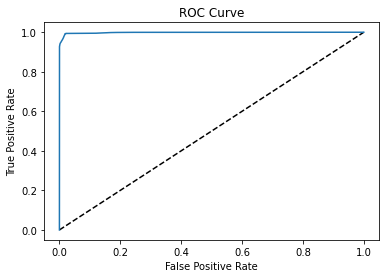



ROC AUC score: 0.9984686571887664
-------------------------------------------------------


In [36]:
random_rf = tune_model(RandomizedSearchCV, forest, params_rf, 5)